In [2]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report)
from statannotations.Annotator import Annotator
from biom import load_table

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load data

In [3]:
#load rpca results
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord.txt')
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord.txt')
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord.txt')
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord.txt')
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord.txt')
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord.txt')
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [4]:
print(metadata.shape)
display(metadata.head())

(374, 16)


,season,subjects,add_0c,add_0c_group,facility,timepoint,traintest_0,traintest_1,traintest_2,traintest_3,traintest_4,traintest_5,traintest_6,traintest_7,traintest_8,traintest_9
sample_name,,,,,,,,,,,,,,,,
soil.hip.CMU.17.10.2017.08.11.day3,summer,17-10,49.75,early,FIRS,3,train,train,train,test,train,test,test,test,train,train
soil.hip.CMU.17.10.2017.08.22.day14,summer,17-10,322.80,advanced,FIRS,14,test,train,train,train,test,train,train,train,test,train
soil.hip.CMU.17.10.2017.08.28.day20,summer,17-10,477.80,advanced,FIRS,20,train,test,train,train,test,train,test,train,train,train
soil.hip.CMU.17.10.2017.08.09.day1,summer,17-10,0.00,initial,FIRS,1,test,train,train,train,train,train,train,train,train,test
soil.hip.CMU.17.10.2017.08.23.day15,summer,17-10,348.05,advanced,FIRS,15,train,train,train,test,train,train,test,train,train,train


## Define functions

In [14]:
def rf_acc(ord_tables, ord_ids, shared_mt, cat_of_interest,
           ordination=True, n_estimators=100, random_state=42,
           optimize=False, param_grid=None, **kwargs):

    #initialize dataframe to store results
    metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                       'Report', 'Optimization'])
    acc_ord = {}
    
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        
        if ordination:
            X = ord.samples.copy()
        else: 
            X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        acc_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(10)]:
            
            #split data into pre-defined train and test sets
            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if optimize:
                print(f'Optimizing hyperparameters for {omic}, {fold}...')
                #initialize random forest
                rf = RandomForestClassifier(random_state=random_state)
                #hyperparameter optimization
                grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                           cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
                grid_search.fit(X_train.values, y_train)
                #get best model
                best_rf = grid_search.best_estimator_
                #save best parameters and print results
                best_params = grid_search.best_params_.copy()
                best_params['best_score'] = grid_search.best_score_
                print(f'Best parameters found: {grid_search.best_params_}')
                print(f'Best cross-validation accuracy: {grid_search.best_score_}')

            else:
                #initialize random forest with user-defined parameters
                rf = RandomForestClassifier(n_estimators=n_estimators, 
                                            random_state=random_state, **kwargs)
                rf.fit(X_train.values, y_train)
                best_params = 'None'
                best_rf = rf
            
            #predict on test set
            y_pred = best_rf.predict(X_test)
            #get accuracy and classification report
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            #save results for each fold
            acc_fold[fold] = (accuracy, report, best_params)
        
        #save results for each omic
        acc_ord[omic] = acc_fold

    #create df with metrics
    for omic, acc_fold in acc_ord.items():
        for fold, metrics in acc_fold.items():
            metrics_df = metrics_df.append({'Omic': omic, 'Fold': fold, 
                                            'Accuracy': metrics[0], 
                                            'Report': metrics[1], 
                                            'Optimization': metrics[2]}, 
                                            ignore_index=True)
    return metrics_df

## Ordination-based classification

### RF default params

In [20]:
#FACILITY
acc_ord_facility = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, ord_joint],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                   "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                          shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                          random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_facility.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.797872,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.744681,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.734043,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.765957,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.755319,precision recall f1-score ...,None


In [21]:
#STAGE OF DECOPMPOSITION (ADD 0C)
acc_ord_stage = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_stage.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.446809,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.468085,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.489362,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.457447,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.510638,precision recall f1-score ...,None


In [22]:
#SEASON
acc_ord_season = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='season', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_season.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.787234,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.797872,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.776596,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.723404,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.829787,precision recall f1-score ...,None


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:3.363e-01 Stat=4.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

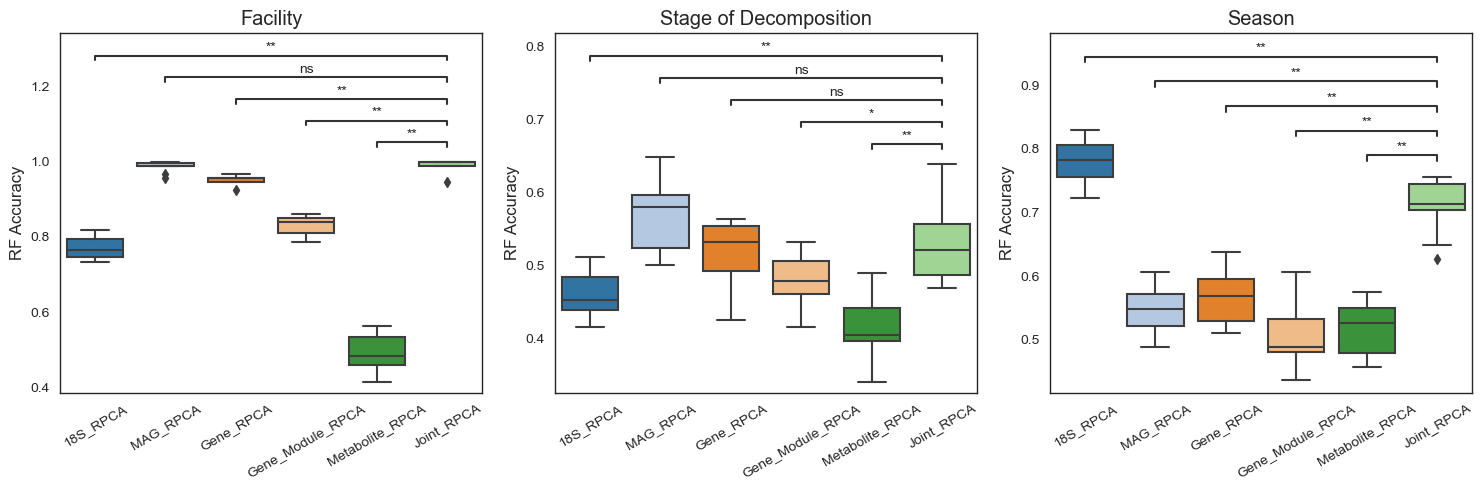

In [23]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility, acc_ord_stage, acc_ord_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Hyper-parameter optimization

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [10]:
#FACILITY
acc_ord_facility_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                          ord_gene_module, ord_metabolite, ord_joint],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                       "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                              shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                              random_state=42, optimize=True, param_grid=param_grid)

In [ ]:
display(acc_ord_facility.head())